In [2]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller

from arch import arch_model


import matplotlib.pyplot as plt
import matplotlib as mpl


A function that can plot the graph for data visualization

In [8]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 


Okay, Lets define come constants here, we are using the file msci_china.csv. The data ranges from 1996 to 2019

In [9]:
px_last = 'PX_LAST'
px_volume = 'PX_VOLUME'
date = 'Date'
df = pd.read_csv('msci_china.csv')
df = df.dropna(how='all')
#df.set_index(date,inplace = True)
print df.head()

         Date  PX_LAST     PX_VOLUME
0  31/12/2018  9.09068  1.784360e+09
1  28/12/2018  9.02903  8.362607e+09
2  27/12/2018  8.99697  9.766580e+09
3  26/12/2018  9.03818  4.499892e+09
4  25/12/2018  8.95016  6.396083e+09


Looks good now. Lets try to plot the graph of the PX_LAST column

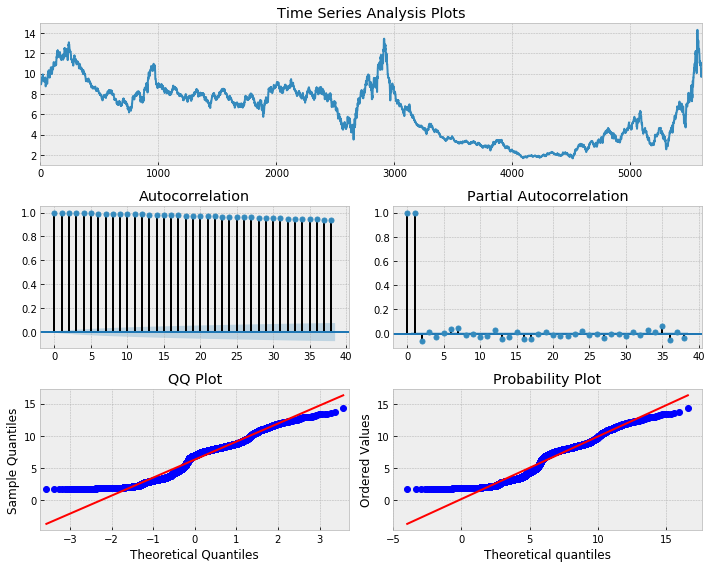

In [10]:
tsplot(df[px_last])

The graph doesn't look very good now. Lets have a stionary test to see if the series is stationary.(I doubt it's not :)) To dig deeper into the data, plot a histogram of the series to see what it looks like 

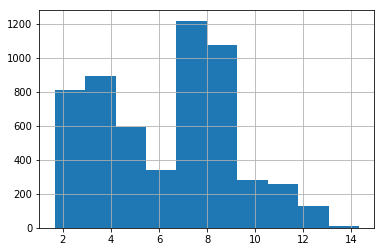

In [11]:
df[px_last].hist()

Clearly, we don't have a normal distribution here, hence our data is non stationay. Lets randomly split the series into 3 pieces with 25% of total of the first one and 75 % of total of the last two to check their mean and variance

In [12]:
one, two, three = np.split(
        df[px_last].sample(
        frac=1), [int(.25*len(df[px_last])),
        int(.75*len(df[px_last]))])
print ('===================')
print ("series one: mean: " + str(one.mean()) + " variance: " + str(one.var()))
print ("series two: mean: " + str(two.mean()) + " variance: " + str(two.var()))
print ("series three: mean: " + str(three.mean()) + " variance: " + str(three.var()))
print ('===================')

series one: mean: 6.28227480742 variance: 8.04031809341
series two: mean: 6.31335024251 variance: 7.80293685817
series three: mean: 6.27986437634 variance: 7.74945493754


In [13]:
adf_test = adfuller(df[px_last])

print "ADF = " + str(adf_test[0])
print "p-value = " +str(adf_test[1])

ADF = -1.8600606934904034
p-value = 0.35107663519857324


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
The threshold is 1%, 5%, 10%, and clear our data is far from stationary. Lets apply a log return a first differernce below 

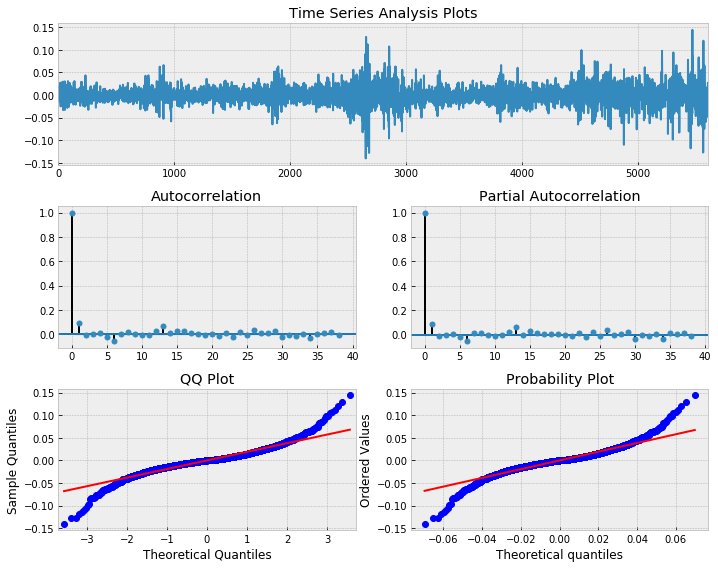

In [14]:
df_log = np.log(df[px_last]/df[px_last].shift(1)).dropna(how='all')
tsplot(df_log)

1   -0.006805
2   -0.003557
3    0.004570
4   -0.009786
5    0.000502
Name: PX_LAST, dtype: float64


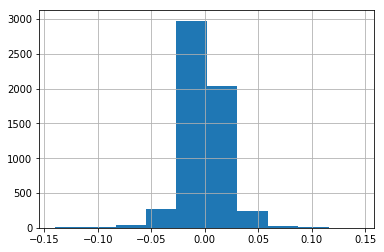

In [15]:
#print(df_log.index)

#df_log = df_log.reindex(df[date])
#new_series = pd.Series(data['numerical_column'].values , index=data['dates'])
print(df_log.head())
df_log.hist()

In [16]:
adf_test_log = adfuller(df_log)

print "ADF = " + str(adf_test_log[0])
print "p-value = " +str(adf_test_log[1])

ADF = -17.775475281758965
p-value = 3.293861385260083e-30


In [17]:
#re index the data to avoid warnings 
df_log.index = pd.RangeIndex(start=1, stop=len(df_log.index)+1, step=1)
print (df_log.head())

1   -0.006805
2   -0.003557
3    0.004570
4   -0.009786
5    0.000502
Name: PX_LAST, dtype: float64


The data looks good now, lets have use ARMR to get the best value pair of p and q

In [12]:
best_aic = np.inf 
best_p = None
best_q = None
best_mdl = None

rng = range(5) # iterate 5 times to find the most optimal value pair of p and 
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(df_log, order=(i, j)).fit(
                method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_p = i
                best_q = j
                best_mdl = tmp_mdl
        except: continue

print (best_mdl.summary())
print('aic:'+ str(best_aic) +'|' +'order: '+ str(best_p) + str(best_q))


/anaconda3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

                              ARMA Model Results                              
Dep. Variable:                PX_LAST   No. Observations:                 5608
Model:                     ARMA(4, 4)   Log Likelihood               14293.151
Method:                           mle   S.D. of innovations              0.019
Date:                Thu, 04 Jul 2019   AIC                         -28568.301
Time:                        23:49:04   BIC                         -28508.614
Sample:                             0   HQIC                        -28547.503
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.PX_LAST     1.3506      0.155      8.719      0.000       1.047       1.654
ar.L2.PX_LAST    -1.4446      0.149     -9.683      0.000      -1.737      -1.152
ar.L3.PX_LAST     1.0266      0.229     

In [18]:
model = arch_model(df_log,mean='ZERO', vol='GARCH', p=4, q=4)

In [19]:
model_result = model.fit()
model_result.summary()

Iteration:      1,   Func. Count:     11,   Neg. LLF: -15277.5371412
Iteration:      2,   Func. Count:     26,   Neg. LLF: -15277.6111221
Iteration:      3,   Func. Count:     38,   Neg. LLF: -15280.2924269
Iteration:      4,   Func. Count:     50,   Neg. LLF: -15281.4453986
Iteration:      5,   Func. Count:     62,   Neg. LLF: -15282.230359
Iteration:      6,   Func. Count:     75,   Neg. LLF: -15282.4818813
Iteration:      7,   Func. Count:     88,   Neg. LLF: -15282.9401018
Iteration:      8,   Func. Count:    100,   Neg. LLF: -15283.7802773
Iteration:      9,   Func. Count:    112,   Neg. LLF: -15284.2687955
Iteration:     10,   Func. Count:    124,   Neg. LLF: -15284.7808808
Iteration:     11,   Func. Count:    136,   Neg. LLF: -15284.9814901
Iteration:     12,   Func. Count:    148,   Neg. LLF: -15285.1244724
Iteration:     13,   Func. Count:    160,   Neg. LLF: -15285.3667946
Iteration:     14,   Func. Count:    172,   Neg. LLF: -15285.5877715
Iteration:     15,   Func. Count:  

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                PX_LAST   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                15285.9
Distribution:                  Normal   AIC:                          -30553.9
Method:            Maximum Likelihood   BIC:                          -30494.2
                                        No. Observations:                 5608
Date:                Fri, Jul 05 2019   Df Residuals:                     5599
Time:                        00:08:59   Df Model:                            9
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.4086e-06  4.912e-11  8.976e+04      0.000  [4.408e-06,4.409e-06]
alpha[1]       0.0455  1.439e-02      3.160  1.579e-03  [1.727e-02,7.368e-02]
alpha[2]       0.0569  1.915e-02      2.973  2.950e-03  [1.939e-02,9.445e-02]
alpha[3]       0.0603  1.765e-02      3.415  6.373e-04  [2.569e-02,9.489e-02]
alpha[4]   5.2327e-10  1.687e-02  3.101e-08      1.000 [-3.307e-02,3.307e-02]
beta[1]    1.8476e-09      0.284  6.517e-09      1.000      [ -0.556,  0.556]
beta[2]        0.4433      0.317      1.397      0.163      [ -0.179,  1.066]
beta[3]        0.2723      0.263      1.035      0.301      [ -0.244,  0.788]
beta[4]        0.1129      0.191      0.591      0.555      [ -0.262,  0.488]
=============================================================================

Covariance estimator: robust
"""

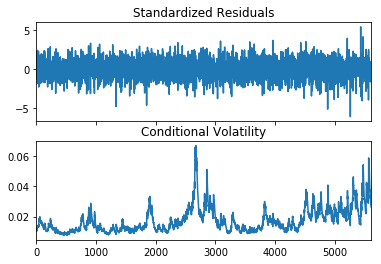

In [24]:
fig = model_result.plot()